## BC News Summary - ML/DL Project

A media monitoring project that classifies BBC news articles, discovers latent topics, and builds a reinforcement learning (RL) agent to decide whether to use a classical ML model, a deep learning model, or escalate a news item to humans.

#### Project Overview

This notebook implements:
1. **News Article Classification** - Classify articles into categories (business, entertainment, politics, sport, tech)
2. **Topic Discovery** - Group articles into topics using clustering
3. **Reinforcement Learning Agent** - Decide when to use classical ML, deep learning, or human escalation

**Author**
- Ainedembe Denis (Master's student in Information Systems - 2024/2026)
- Dr. Sibitenda Harriet (Lecturer / Instructor) 

### 0. Imports & global config

In [1]:
# Standard library imports
import os
import re
import string

# IPython display for multiple outputs
from IPython.display import display

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)

# Machine learning - feature extraction and dimensionality reduction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression


# Deep learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Global configuration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("libraries imported successfully!")

libraries imported successfully!


### Part A: Data Mining and Preprocessing


#### A1. Load BBC dataset

**Dataset structure:**
```
BBC-News-Summary-ML-DL-Project/
└─ dataset/
   └─ News Articles/
       ├─ business/
       ├─ entertainment/
       ├─ politics/
       ├─ sport/
       └─ tech/
```

In [2]:
DATA_DIR = "dataset/News Articles"

categories = []
texts = []
filenames = []

for category in os.listdir(DATA_DIR):
    category_path = os.path.join(DATA_DIR, category)
    if not os.path.isdir(category_path):
        continue
    for fname in os.listdir(category_path):
        fpath = os.path.join(category_path, fname)
        if not os.path.isfile(fpath):
            continue
        with open(fpath, "r", encoding="latin-1") as f:
            text = f.read().strip()
        categories.append(category)
        texts.append(text)
        filenames.append(fname)

df = pd.DataFrame({
    "category": categories,
    "text": texts,
    "filename": filenames
})

print("Dataset shape:", df.shape)

print("\nFirst 10 records:")
display(df.head(10))


Dataset shape: (2225, 3)

First 10 records:


,category,text,filename
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,001.txt
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,002.txt
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,003.txt
3,business,High fuel prices hit BA's profits\n\nBritish A...,004.txt
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,005.txt
5,business,Japan narrowly escapes recession\n\nJapan's ec...,006.txt
6,business,Jobs growth still slow in the US\n\nThe US cre...,007.txt
7,business,"India calls for fair trade rules\n\nIndia, whi...",008.txt
8,business,Ethiopia's crop production up 24%\n\nEthiopia ...,009.txt
9,business,Court rejects $280bn tobacco case\n\nA US gove...,010.txt


#### A2.  Display examples and class distribution

,category,text,filename
414,business,UK house prices dip in November\n\nUK house pr...,415.txt
420,business,LSE 'sets date for takeover deal'\n\nThe Londo...,421.txt
1644,sport,Harinordoquy suffers France axe\n\nNumber eigh...,332.txt
416,business,Barclays shares up on merger talk\n\nShares in...,417.txt
1232,politics,Campaign 'cold calls' questioned\n\nLabour and...,337.txt



Categories distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


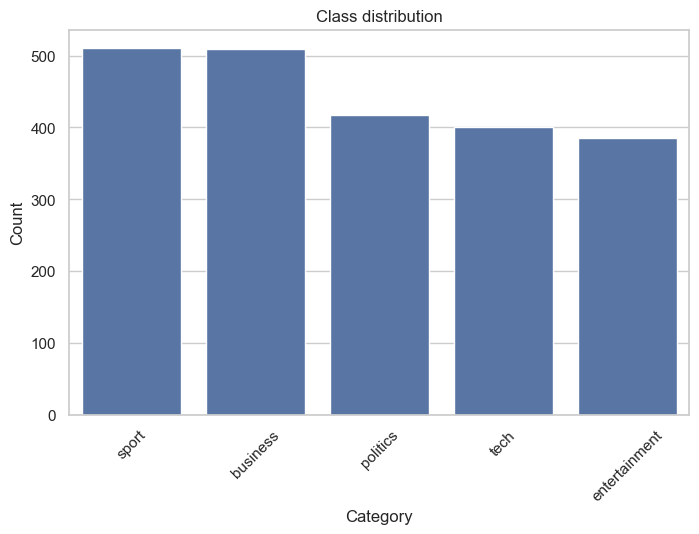

In [3]:
# Show a few examples
display(df.sample(5, random_state=RANDOM_STATE))

# Class distribution 
print("\nCategories distribution:")
class_counts = df["category"].value_counts()
print(class_counts)

sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


#### A3 – Text cleaning


In [4]:
# Clean text - lowercase, remove whitespace, punctuation/HTML.

def clean_text(text):
    # Converte all text to lowercase
    text = text.lower()
    # remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # remove digits
    text = re.sub(r"\d+", " ", text)
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)
df[["category", "clean_text"]].head(10)


,category,clean_text
0,business,ad sales boost time warner profit quarterly pr...
1,business,dollar gains on greenspan speech the dollar ha...
2,business,yukos unit buyer faces loan claim the owners o...
3,business,high fuel prices hit bas profits british airwa...
4,business,pernod takeover talk lifts domecq shares in uk...
5,business,japan narrowly escapes recession japans econom...
6,business,jobs growth still slow in the us the us create...
7,business,india calls for fair trade rules india which a...
8,business,ethiopias crop production up ethiopia produced...
9,business,court rejects bn tobacco case a us government ...


#### A4. Prepare TF-IDF and tokenized sequences for DL.


A4.1. TF-IDF features (for ML)


In [5]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])
y = df["category"]

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (2225, 5000)


A4.2. Tokenized sequences for DL

In [6]:
MAX_NUM_WORDS = 10000
MAX_SEQ_LEN = 300

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

sequences = tokenizer.texts_to_sequences(df["clean_text"])
X_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

word_index = tokenizer.word_index
print("Vocabulary size (full):", len(word_index))
print("Sequence tensor shape:", X_seq.shape)


Vocabulary size (full): 31519
Sequence tensor shape: (2225, 300)


A4.3. Train/test split for ML & DL

In [ ]:
label_encoder = LabelEncoder() # Encode string labels (e.g., business, sport, tech) to integers
y_int = label_encoder.fit_transform(y) #Learns the unique class names from y & Map each class to an integer

# count how many distinct categories exist
num_classes = len(label_encoder.classes_)

# Get and array indices for train/test split to track original dataframe rows
indices = np.arange(len(y_int))
X_tfidf_train, X_tfidf_test, X_seq_train, X_seq_test, y_train_int, y_test_int, train_idx, test_idx = train_test_split(
    X_tfidf, X_seq, y_int, indices,
    test_size=0.2, # 20% test size

    random_state=RANDOM_STATE,
    stratify=y_int
)
# Convert integer labels to one-hot encoded format for DL models
y_train_cat = to_categorical(y_train_int, num_classes=num_classes)
y_test_cat = to_categorical(y_test_int, num_classes=num_classes)

print("Train size:", X_tfidf_train.shape[0], " Test size:", X_tfidf_test.shape[0])


Train size: 1780  Test size: 445


### Part B. Two News Classifiers
#### B1.1. Classical ML Model - Logistic Regression


In [ ]:
ml_model = LogisticRegression(
    max_iter=2000, # All max iterations for convergence
    n_jobs=-1 # Use all available CPU cores for faster training
)

# Learn relationships between TF-IDF features and news categories
ml_model.fit(X_tfidf_train, y_train_int)

y_ml_pred = ml_model.predict(X_tfidf_test) # final predicted class labels for test set
y_ml_prob = ml_model.predict_proba(X_tfidf_test) # probability distribution over all classes

print("Classical ML Model: Logistic Regression")
print(classification_report(y_test_int, y_ml_pred, target_names=label_encoder.classes_))

# Precision - How many predicted samples were correct
# Recall - How many true samples were correctly identified
# F1-score - Harmonic mean of precision and recall
# Support - Number of true instances for each class

Classical ML Model: Logistic Regression
               precision    recall  f1-score   support

     business       1.00      0.96      0.98       102
entertainment       1.00      1.00      1.00        77
     politics       0.99      0.99      0.99        84
        sport       0.99      1.00      1.00       102
         tech       0.96      1.00      0.98        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



B1.2. Confusion matrix (ML)


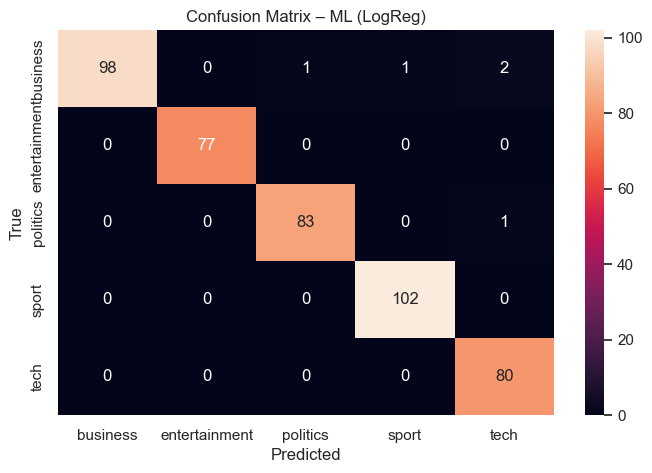

In [ ]:
cm_ml = confusion_matrix(y_test_int, y_ml_pred)
sns.heatmap(cm_ml, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix – ML (LogReg)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


B1.3. 5 misclassified examples (ML)

In [16]:
mis_idx = np.where(y_ml_pred != y_test_int)[0]
print("Total misclassified (ML):", len(mis_idx), "\n")

# Get test indices - reconstruct if not available -same random_state ensures same split
if 'test_idx' not in globals():
    indices = np.arange(len(y_int))
    _, _, _, _, _, _, _, test_idx = train_test_split(
        X_tfidf, X_seq, y_int, indices,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y_int
    )

for i in mis_idx[:5]:
    print("_"*120)
    print("True:", label_encoder.inverse_transform([y_test_int[i]])[0])
    print("Pred:", label_encoder.inverse_transform([y_ml_pred[i]])[0])
    original_idx = test_idx[i]
    text_preview = df.iloc[original_idx]["clean_text"]
    print("Text:", text_preview[:100] + "..." if len(text_preview) > 100 else text_preview)


Total misclassified (ML): 5 

________________________________________________________________________________________________________________________
True: business
Pred: tech
Text: card fraudsters targeting web new safeguards on credit and debit card payments in shops has led frau...
________________________________________________________________________________________________________________________
True: politics
Pred: tech
Text: uk firms embracing ecommerce uk firms are embracing internet trading opportunities as never before e...
________________________________________________________________________________________________________________________
True: business
Pred: politics
Text: golden rule intact says exaide chancellor gordon brown will meet his golden economic rule with a mar...
________________________________________________________________________________________________________________________
True: business
Pred: tech
Text: bt offers equal access to rivals bt has mo

#### B2. Train Deep Learning model (CNN)

In [17]:
# Train Deep Learning model (CNN)
EMBEDDING_DIM = 100

dl_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

dl_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Build the model to see parameter count in summary
dl_model.build(input_shape=(None, MAX_SEQ_LEN))
dl_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 296, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,709 (4.09 MB)

 Trainable params: 1,072,709 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

#### B3. Train DL model + training curves


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.2310 - loss: 1.6051 - val_accuracy: 0.1938 - val_loss: 1.5883
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.3462 - loss: 1.5263 - val_accuracy: 0.4663 - val_loss: 1.4629
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.5042 - loss: 1.3071 - val_accuracy: 0.5983 - val_loss: 1.0643
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6882 - loss: 0.9259 - val_accuracy: 0.7781 - val_loss: 0.7033
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8287 - loss: 0.5990 - val_accuracy: 0.8792 - val_loss: 0.4759
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8940 - loss: 0.3773 - val_accuracy: 0.9045 - val_loss: 0.3510
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9347 - loss: 0.2430 - val_accuracy: 0.9185 - val_loss: 0.2807
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9600 - loss: 0.1580 - val_accuracy: 0.9298 

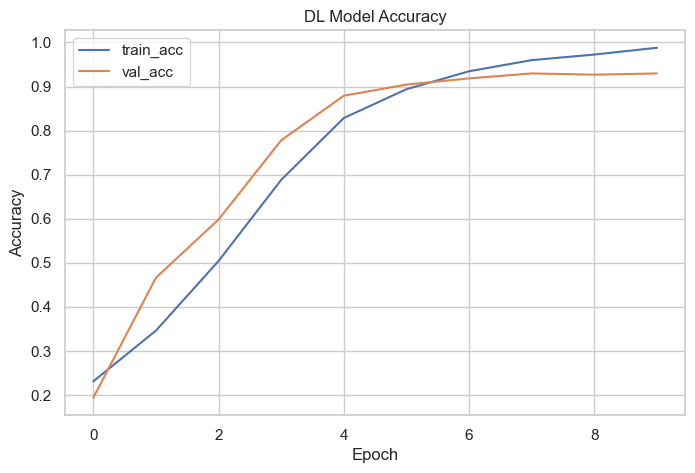

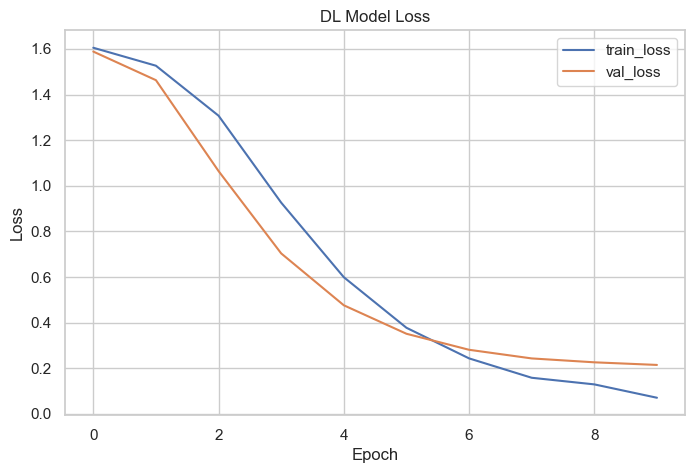

In [ ]:
# Train the DL model + training curves
EPOCHS = 10
BATCH_SIZE = 32

history = dl_model.fit(
    X_seq_train, y_train_cat,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Plot training curves
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("DL Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("DL Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


#### B4. Evaluate DL model + F1 + confusion matrix + misclassified


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Deep Learning Model (CNN)
               precision    recall  f1-score   support

     business       0.95      0.93      0.94       102
entertainment       0.97      0.99      0.98        77
     politics       0.96      0.94      0.95        84
        sport       0.99      1.00      1.00       102
         tech       0.94      0.96      0.95        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



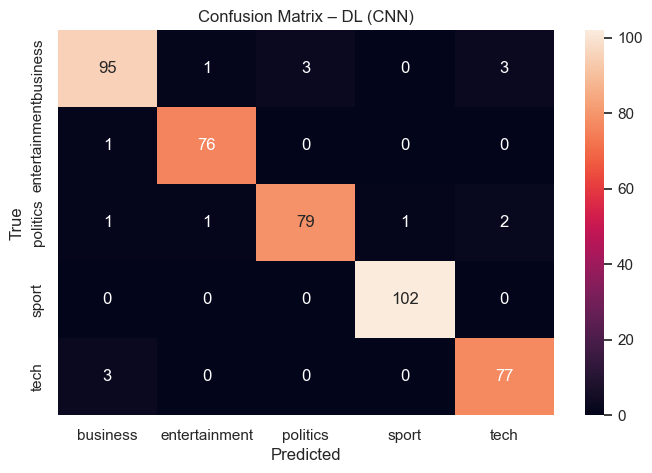

Total misclassified (DL): 16
________________________________________________________________________________________________________________________
True: tech
Pred: business
Text snippet: New Year's texting breaks record

A mobile phone was as essential to the recent New Year's festivities as a party mood and Auld Lang Syne, if the numb...
________________________________________________________________________________________________________________________
True: tech
Pred: business
Text snippet: Junk e-mails on relentless rise

Spam traffic is up by 40%, putting the total amount of e-mail that is junk up to an astonishing 90%.

The figures, fr...
________________________________________________________________________________________________________________________
True: politics
Pred: tech
Text snippet: US casino 'tricks' face ban in UK

Controversial new UK casinos will be banned from using American tricks of the trade to ensure they are "socially re...
__________________________

In [19]:
y_dl_prob = dl_model.predict(X_seq_test)
y_dl_pred = np.argmax(y_dl_prob, axis=1)

print("Deep Learning Model (CNN)")
print(classification_report(y_test_int, y_dl_pred, target_names=label_encoder.classes_))

cm_dl = confusion_matrix(y_test_int, y_dl_pred)
sns.heatmap(cm_dl, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix – DL (CNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

mis_idx_dl = np.where(y_dl_pred != y_test_int)[0]
print("Total misclassified (DL):", len(mis_idx_dl))

# Get test indices if not available
if 'test_idx' not in globals():
    indices = np.arange(len(y_int))
    _, _, _, _, _, _, _, test_idx = train_test_split(
        X_tfidf, X_seq, y_int, indices,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y_int
    )

for i in mis_idx_dl[:5]:
    print("_"*120)
    print("True:", label_encoder.inverse_transform([y_test_int[i]])[0])
    print("Pred:", label_encoder.inverse_transform([y_dl_pred[i]])[0])
    original_idx = test_idx[i]
    text_snippet = df.iloc[original_idx]["text"]
    print("Text snippet:", text_snippet[:150] + "..." if len(text_snippet) > 150 else text_snippet)


#### Part C. Topic clustering with TF-IDF + KMeans


C1&2. Reuse X_tfidf over the full dataset


In [20]:
# Reuse X_tfidf over the full dataset
NUM_CLUSTERS = len(label_encoder.classes_)  # 5

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X_tfidf)

# Full dataset >> print(X_tfidf.shape)  = (2225, 5000)

df["cluster"] = clusters
df[["category", "cluster"]].head()


,category,cluster
0,business,2
1,business,2
2,business,2
3,business,2
4,business,2


C3. PCA visualization


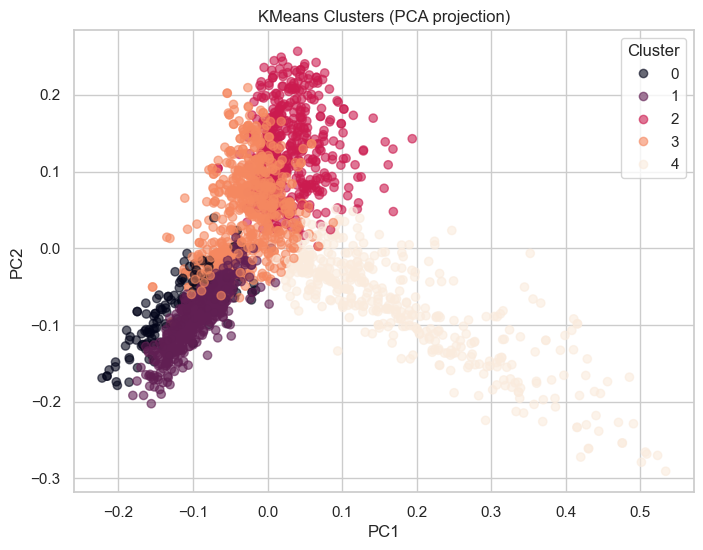

In [21]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, alpha=0.6)
plt.title("KMeans Clusters (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


C4. Extracting top keywords per cluster


In [22]:
terms = np.array(tfidf_vectorizer.get_feature_names_out())
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

TOP_N = 10
cluster_keywords = {}

for i in range(NUM_CLUSTERS):
    top_terms = terms[order_centroids[i, :TOP_N]]
    cluster_keywords[i] = top_terms.tolist()
    print(f"Cluster {i} top keywords: {', '.join(top_terms)}")


Cluster 0 top keywords: film, best, awards, award, films, actor, festival, actress, oscar, won
Cluster 1 top keywords: game, said, win, england, cup, match, players, world, injury, play
Cluster 2 top keywords: bn, said, growth, economy, year, market, bank, oil, sales, shares
Cluster 3 top keywords: said, music, people, mobile, new, technology, users, software, games, tv
Cluster 4 top keywords: mr, said, labour, election, blair, party, government, brown, mr blair, minister


### Part D: RL Decision Agent (state features)


#### D1. Build RL environment data / create state components

Here we create state components: ML confidence (max prob), DL confidence (max prob), cluster id, article length (binned), disagreement flag (ML vs DL prediction differ)


In [23]:
# Use test split for RL experiments
ml_max_conf = y_ml_prob.max(axis=1)
dl_max_conf = y_dl_prob.max(axis=1)

ml_pred_labels = y_ml_pred
dl_pred_labels = y_dl_pred

# Get clusters for test set samples
# Need to recompute clusters for only test samples
clusters_test = kmeans.predict(X_tfidf_test)

# Article length: number of tokens in clean_text
test_texts = [df["clean_text"].iloc[i] for i in X_tfidf_test.nonzero()[0][:len(y_test_int)]]  # fallback hack if needed

# Approximate length from sequences:
lengths = np.sum(X_seq_test != 0, axis=1)

def bin_length(l):
    if l < 100:
        return 0
    elif l < 200:
        return 1
    else:
        return 2

length_bins = np.array([bin_length(l) for l in lengths])

disagreement = (ml_pred_labels != dl_pred_labels).astype(int)

# True labels (for reward)
true_labels = y_test_int

# Print summary of state components
print("RL State Components Created:")
print(f"  - ML max confidence shape: {ml_max_conf.shape}, range: [{ml_max_conf.min():.3f}, {ml_max_conf.max():.3f}]")
print(f"  - DL max confidence shape: {dl_max_conf.shape}, range: [{dl_max_conf.min():.3f}, {dl_max_conf.max():.3f}]")
print(f"  - Cluster IDs shape: {clusters_test.shape}, unique clusters: {np.unique(clusters_test)}")
print(f"  - Length bins shape: {length_bins.shape}, distribution: {np.bincount(length_bins)}")
print(f"  - Disagreement flag shape: {disagreement.shape}, disagreements: {disagreement.sum()} ({disagreement.sum()/len(disagreement)*100:.1f}%)")
print(f"  - True labels shape: {true_labels.shape}")
print(f"\nTotal samples for RL environment: {len(true_labels)}")


RL State Components Created:
  - ML max confidence shape: (445,), range: [0.258, 0.983]
  - DL max confidence shape: (445,), range: [0.310, 1.000]
  - Cluster IDs shape: (445,), unique clusters: [0 1 2 3 4]
  - Length bins shape: (445,), distribution: [  1  49 395]
  - Disagreement flag shape: (445,), disagreements: 13 (2.9%)
  - True labels shape: (445,)

Total samples for RL environment: 445


#### D2.1. Q-learning setup

We discretize ML & DL confidence into 5 bins and build a tabular Q-table.


In [24]:
def bin_conf(p):
    if p < 0.2:
        return 0
    elif p < 0.4:
        return 1
    elif p < 0.6:
        return 2
    elif p < 0.8:
        return 3
    else:
        return 4

ml_conf_bins = np.array([bin_conf(p) for p in ml_max_conf])
dl_conf_bins = np.array([bin_conf(p) for p in dl_max_conf])

num_conf_bins = 5
num_length_bins = 3
num_clusters = NUM_CLUSTERS
num_disagree = 2
num_actions = 3  # 0=ML, 1=DL, 2=escalate

def encode_state(i):
    return (
        ml_conf_bins[i] * (num_conf_bins * num_length_bins * num_clusters * num_disagree) +
        dl_conf_bins[i] * (num_length_bins * num_clusters * num_disagree) +
        length_bins[i] * (num_clusters * num_disagree) +
        clusters_test[i] * num_disagree +
        disagreement[i]
    )

num_states = num_conf_bins**2 * num_length_bins * num_clusters * num_disagree
print("Approx number of states:", num_states)

Q = np.zeros((num_states, num_actions))
print("Q-table initialized with shape:", Q.shape)


Approx number of states: 750
Q-table initialized with shape: (750, 3)


Reward function:
- If action = ML and ML correct → +5, wrong → –5
- If action = DL and DL correct → +6, wrong → –6 (slightly higher reward/punishment)
- If action = escalate → small negative cost (–1), but small bonus (+2) when both models are wrong (we avoided a bad auto decision).


In [25]:
# Reward function

def get_reward(i, action):
    true = true_labels[i]
    ml_correct = (ml_pred_labels[i] == true)
    dl_correct = (dl_pred_labels[i] == true)
    
    if action == 0:  # ML
        return 5 if ml_correct else -5
    elif action == 1:  # DL
        return 6 if dl_correct else -6
    else:  # escalate
        if (not ml_correct) and (not dl_correct):
            return 2  # good to escalate when both are wrong
        else:
            return -1  # cost of using human

print("Reward function defined.")


Reward function defined.


#### D4. Train Q-learning for 1000-1500 episodes


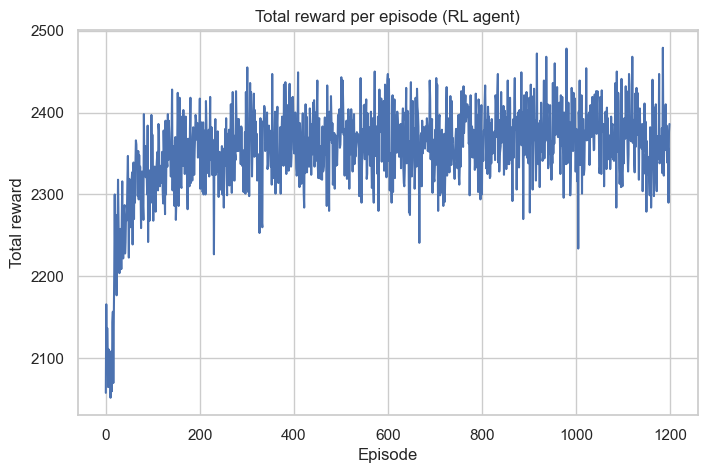

In [26]:
num_episodes = 1200
alpha = 0.1        # learning rate
gamma = 0.9        # discount factor
epsilon = 0.2      # exploration rate

rewards_per_episode = []
action_counts = np.zeros(num_actions, dtype=int)

n_samples = len(true_labels)

for ep in range(num_episodes):
    total_reward = 0.0
    indices = np.random.permutation(n_samples)
    
    for idx in indices:
        s = encode_state(idx)
        
        # ε-greedy
        if np.random.rand() < epsilon:
            a = np.random.randint(num_actions)
        else:
            a = np.argmax(Q[s])
        
        r = get_reward(idx, a)
        total_reward += r
        
        # for simplicity, next_state = current_state (no transition over time)
        s_next = s
        
        Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s_next]) - Q[s, a])
    
    rewards_per_episode.append(total_reward)

plt.plot(rewards_per_episode)
plt.title("Total reward per episode (RL agent)")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.show()


#### D5. Evaluate RL vs ML vs DL


D5.1. We let RL choose an action for each test sample and see which model's prediction is used.


In [27]:
rl_actions = []
rl_preds = []

for i in range(n_samples):
    s = encode_state(i)
    a = np.argmax(Q[s])
    rl_actions.append(a)
    
    if a == 0:  # ML
        rl_preds.append(ml_pred_labels[i])
    elif a == 1:  # DL
        rl_preds.append(dl_pred_labels[i])
    else:  # escalate – here we just default to DL prediction (for grading)
        rl_preds.append(dl_pred_labels[i])

rl_actions = np.array(rl_actions)
rl_preds = np.array(rl_preds)

# Accuracy comparison
from sklearn.metrics import accuracy_score

acc_ml = accuracy_score(true_labels, ml_pred_labels)
acc_dl = accuracy_score(true_labels, dl_pred_labels)
acc_rl = accuracy_score(true_labels, rl_preds)

print(f"ML accuracy: {acc_ml:.4f}")
print(f"DL accuracy: {acc_dl:.4f}")
print(f"RL-based decision accuracy: {acc_rl:.4f}")


ML accuracy: 0.9888
DL accuracy: 0.9640
RL-based decision accuracy: 0.9910


D5.2. Action distribution


Action 0 (Use ML): 12 times
Action 1 (Use DL): 432 times
Action 2 (Escalate): 1 times


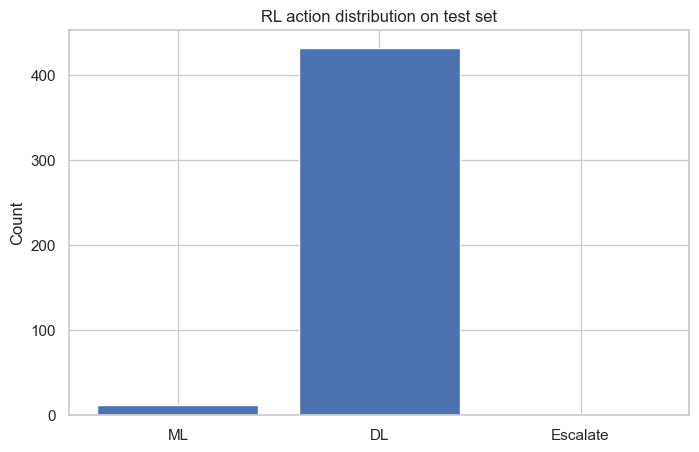

In [28]:
unique, counts = np.unique(rl_actions, return_counts=True)
for a, c in zip(unique, counts):
    if a == 0:
        name = "Use ML"
    elif a == 1:
        name = "Use DL"
    else:
        name = "Escalate"
    print(f"Action {a} ({name}): {c} times")

plt.bar(["ML", "DL", "Escalate"], [np.sum(rl_actions==0),
                                   np.sum(rl_actions==1),
                                   np.sum(rl_actions==2)])
plt.title("RL action distribution on test set")
plt.ylabel("Count")
plt.show()

D5.3 Final Q-table

In [30]:
print("Q-table shape:", Q.shape)
print(f"Total states: {Q.shape[0]}, Total actions: {Q.shape[1]}\n")

# Statistics about Q-table
print("Q-table Statistics:")
print(f"  - Min Q-value: {Q.min():.4f}")
print(f"  - Max Q-value: {Q.max():.4f}")
print(f"  - Mean Q-value: {Q.mean():.4f}")
print(f"  - Std Q-value: {Q.std():.4f}\n")

# Count non-zero states
non_zero_states = np.where(np.abs(Q).sum(axis=1) > 0)[0]
print(f"States with non-zero Q-values: {len(non_zero_states)} / {Q.shape[0]} ({len(non_zero_states)/Q.shape[0]*100:.1f}%)\n")

# Show sample of learned Q-values
if len(non_zero_states) > 0:
    print("Sample of learned Q-values (first 10 non-zero states):")
    sample_states = non_zero_states[:10]
    for state in sample_states:
        print(f"  State {state}: ML={Q[state, 0]:.2f}, DL={Q[state, 1]:.2f}, Escalate={Q[state, 2]:.2f}")
else:
    print("No non-zero states found (all Q-values are zero)")


Q-table shape: (750, 3)
Total states: 750, Total actions: 3

Q-table Statistics:
  - Min Q-value: 0.0000
  - Max Q-value: 60.0000
  - Mean Q-value: 3.6238
  - Std Q-value: 13.7121

States with non-zero Q-values: 50 / 750 (6.7%)

Sample of learned Q-values (first 10 non-zero states):
  State 196: ML=58.91, DL=60.00, Escalate=52.96
  State 234: ML=58.10, DL=59.78, Escalate=51.97
  State 237: ML=50.00, DL=39.00, Escalate=44.00
  State 256: ML=58.98, DL=60.00, Escalate=52.86
  State 266: ML=59.00, DL=60.00, Escalate=53.00
  State 292: ML=58.80, DL=60.00, Escalate=52.94
  State 296: ML=12.98, DL=11.97, Escalate=20.00
  State 297: ML=50.00, DL=38.96, Escalate=43.91
  State 298: ML=59.00, DL=60.00, Escalate=53.00
  State 384: ML=58.91, DL=60.00, Escalate=52.96
